<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_10/s10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!pip install torchinfo
!pip install prettytable
!pip install torch_lr_finder

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports

In [2]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_10")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from utils import preview_images, plot_statistics, show_incorrect_predictions, get_incorrect_predictions, print_train_log
from custom_resnet.custom_resnet import CustomResnet, model_summary
from custom_resnet.data_loader import load_cifar10_data
from custom_resnet.training import training_loop
from custom_resnet.inference import model_test
from custom_resnet.optimizer import Optimization, find_best_lr


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Allocate GPU

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
resnet_model = CustomResnet(base_channels=3,num_classes=10).to(device)
model_summary(resnet_model, input_size=(3,32,32))



Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
CustomResnet                             --                        [1, 3, 32, 32]            [1, 10]                   --                        --
├─Sequential: 1-1                        --                        [1, 3, 32, 32]            [1, 64, 32, 32]           --                        --
│    └─Conv2d: 2-1                       [3, 3]                    [1, 3, 32, 32]            [1, 64, 32, 32]           1,728                     1,769,472
│    └─BatchNorm2d: 2-2                  --                        [1, 64, 32, 32]           [1, 64, 32, 32]           128                       128
│    └─ReLU: 2-3                         --                        [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    └─Dropout: 2-4                      --                        [1, 64, 32, 32]           [1, 

/content/ERA_V1/session_10/custom_resnet/custom_resnet.py:161: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Define Transforms

In [21]:
train_transforms = A.Compose(
    [
        #A.augmentations.crops.transforms.CropAndPad(-4, p=0.5),
        AA.crops.transforms.RandomResizedCrop(height = 32,width = 32,p=0.2),
        A.HorizontalFlip(p=0.2),
        AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=8,
                                                max_width=8, min_holes = 1,
                                                min_height=8, min_width=8,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None),

        A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
        ToTensorV2(),
    ]
)
test_transforms = A.Compose([

    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
    ToTensorV2(),
])

Define train and test loaders

In [22]:
torch.manual_seed(1)
batch_size = 512
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader, test_loader, class_names = load_cifar10_data(train_transforms, test_transforms, batch_size, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


Preview Augmentations

(3, 32, 32)


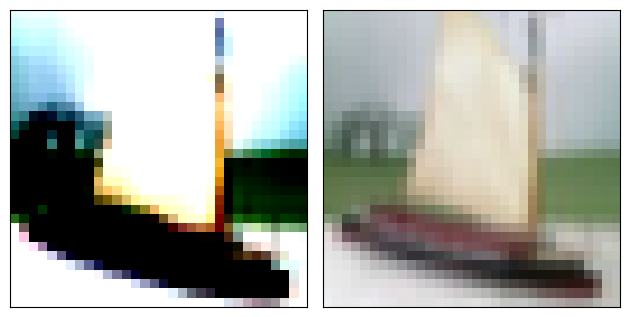

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

def preview_augmentations(train_loader, image_transform):
    batch_data, batch_label = next(iter(train_loader))
    preview_img = np.asarray(batch_data[0].squeeze())
    #preview_img = (preview_img*255./np.max(preview_img)).astype('uint8')
    preview_label = batch_label[0]
    fig, axs = plt.subplots(1, 2)
    plt.tight_layout()
    un_normalize_transform = transforms.Compose([transforms.Normalize((0.,0.,0.,),(1./0.247,1./0.244,1./0.262)),
                                                 transforms.Normalize((-0.491,-0.482,-0.447),(1.0,1.0,1.0))])
    un_normalized_img = un_normalize_transform(batch_data[0].squeeze())
    un_normalized_img = np.asarray(un_normalized_img)
    print(un_normalized_img.shape)
    transformed_numpy_img = image_transform(image = un_normalized_img)["image"]
    #transformed_numpy_img = (transformed_numpy_img*255./np.max(transformed_numpy_img)).astype('uint8')
    axs[0].imshow(preview_img.transpose((1,2,0)))
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].imshow(transformed_numpy_img.transpose((1,2,0)))
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    plt.tight_layout()
    plt.show()

img_transforms = A.Compose([AA.crops.transforms.RandomResizedCrop(height= 32,width = 32,p=0.5)])
preview_augmentations(train_loader, img_transforms)

Show sample Images from the dataset

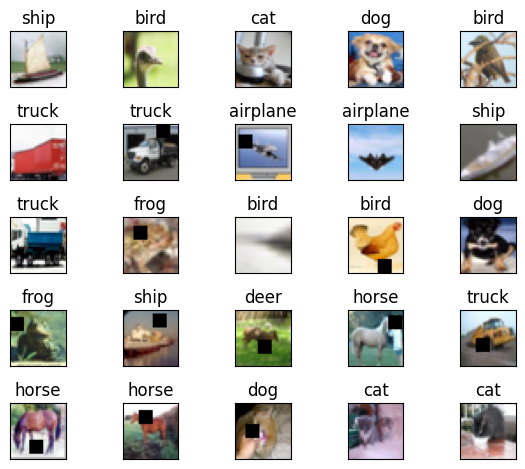

In [23]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Train model using Batch Normalization

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.38E-02


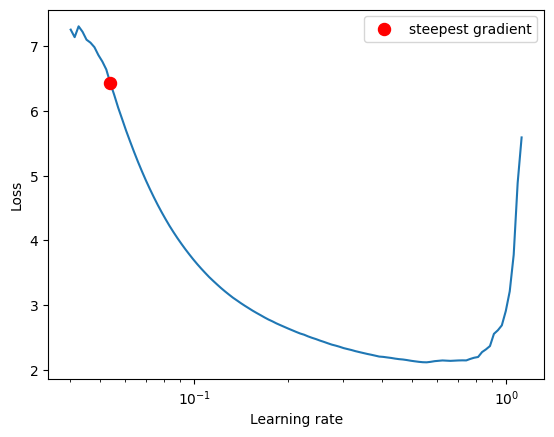

In [26]:
drop_out = 0.0
num_epochs=24
resnet_model = CustomResnet(base_channels=3, num_classes=10,drop_out_probability=drop_out).to(device)
criterion = nn.CrossEntropyLoss(reduction='mean')
optim_obj = Optimization(resnet_model, device, train_loader, criterion, num_epochs)
lr_history = find_best_lr(resnet_model, train_loader, optim_obj.optimizer, criterion, device)


In [27]:
from torch.optim.lr_scheduler import OneCycleLR
#optim_obj.define_scheduler(max_lr=4.93E-2)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lr_values = []
def define_scheduler(max_lr):
    scheduler = OneCycleLR(
        optim_obj.optimizer,
        max_lr = max_lr,
        steps_per_epoch=len(optim_obj.train_loader),
        epochs = num_epochs,
        pct_start = 5./num_epochs,
        div_factor=1000,
        three_phase=False,
        final_div_factor= 100,
        anneal_strategy='linear',
        verbose=False
        )
    return scheduler

max_lr = 5.38e-2
optim_obj.scheduler = define_scheduler(max_lr)

for epoch in range(1,num_epochs+1):
    lr_values.append(optim_obj.scheduler.get_lr())
    print(f"epoch: {epoch}\t learning rate: {optim_obj.scheduler.get_last_lr()[0]}")
    this_train_loss = training_loop(resnet_model, device, train_loader, optim_obj.optimizer, optim_obj.scheduler, criterion, train_acc, train_losses)
    this_loss = model_test(resnet_model, device, test_loader, criterion, test_acc, test_losses)
    #optim_obj.scheduler.step()



epoch: 1	 learning rate: 5.38e-05


loss=1.5221972465515137 batch_id=97 Accuracy = 43.20: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]



Test set: Average loss: 0.0027, Accuracy: 5355/10000 (53.55%)

epoch: 2	 learning rate: 0.01082502208588957


loss=1.198857307434082 batch_id=97 Accuracy = 57.36: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]



Test set: Average loss: 0.0028, Accuracy: 5677/10000 (56.77%)

epoch: 3	 learning rate: 0.02159624417177914


loss=1.0394009351730347 batch_id=97 Accuracy = 66.09: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]



Test set: Average loss: 0.0019, Accuracy: 6801/10000 (68.01%)

epoch: 4	 learning rate: 0.03236746625766871


loss=0.9707741737365723 batch_id=97 Accuracy = 70.39: 100%|██████████| 98/98 [00:26<00:00,  3.70it/s]



Test set: Average loss: 0.0026, Accuracy: 5737/10000 (57.37%)

epoch: 5	 learning rate: 0.04313868834355828


loss=0.7988459467887878 batch_id=97 Accuracy = 70.09: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]



Test set: Average loss: 0.0028, Accuracy: 6034/10000 (60.34%)

epoch: 6	 learning rate: 0.053771106626208376


loss=0.8010309934616089 batch_id=97 Accuracy = 70.86: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]



Test set: Average loss: 0.0024, Accuracy: 5953/10000 (59.53%)

epoch: 7	 learning rate: 0.05093955599462943


loss=0.9250615239143372 batch_id=97 Accuracy = 71.30: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]



Test set: Average loss: 0.0020, Accuracy: 6672/10000 (66.72%)

epoch: 8	 learning rate: 0.04810800536305049


loss=0.7089486122131348 batch_id=97 Accuracy = 72.47: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]



Test set: Average loss: 0.0022, Accuracy: 6367/10000 (63.67%)

epoch: 9	 learning rate: 0.04527645473147154


loss=0.6778666377067566 batch_id=97 Accuracy = 72.74: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]



Test set: Average loss: 0.0017, Accuracy: 7082/10000 (70.82%)

epoch: 10	 learning rate: 0.042444904099892586


loss=0.6653421521186829 batch_id=97 Accuracy = 73.36: 100%|██████████| 98/98 [00:26<00:00,  3.75it/s]



Test set: Average loss: 0.0018, Accuracy: 6874/10000 (68.74%)

epoch: 11	 learning rate: 0.03961335346831364


loss=0.7907384037971497 batch_id=97 Accuracy = 73.81: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]



Test set: Average loss: 0.0015, Accuracy: 7450/10000 (74.50%)

epoch: 12	 learning rate: 0.0367818028367347


loss=0.8344749212265015 batch_id=97 Accuracy = 74.09: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]



Test set: Average loss: 0.0017, Accuracy: 7045/10000 (70.45%)

epoch: 13	 learning rate: 0.03395025220515575


loss=0.7848055958747864 batch_id=97 Accuracy = 74.65: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]



Test set: Average loss: 0.0015, Accuracy: 7392/10000 (73.92%)

epoch: 14	 learning rate: 0.0311187015735768


loss=0.7340039014816284 batch_id=97 Accuracy = 75.43: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]



Test set: Average loss: 0.0015, Accuracy: 7345/10000 (73.45%)

epoch: 15	 learning rate: 0.028287150941997852


loss=0.6354600191116333 batch_id=97 Accuracy = 75.92: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]



Test set: Average loss: 0.0015, Accuracy: 7411/10000 (74.11%)

epoch: 16	 learning rate: 0.025455600310418904


loss=0.7647168040275574 batch_id=97 Accuracy = 77.13: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]



Test set: Average loss: 0.0017, Accuracy: 7123/10000 (71.23%)

epoch: 17	 learning rate: 0.02262404967883996


loss=0.6287383437156677 batch_id=97 Accuracy = 77.73: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]



Test set: Average loss: 0.0012, Accuracy: 7803/10000 (78.03%)

epoch: 18	 learning rate: 0.019792499047261013


loss=0.6640418171882629 batch_id=97 Accuracy = 78.56: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]



Test set: Average loss: 0.0016, Accuracy: 7420/10000 (74.20%)

epoch: 19	 learning rate: 0.01696094841568206


loss=0.5083227157592773 batch_id=97 Accuracy = 79.58: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]



Test set: Average loss: 0.0011, Accuracy: 8111/10000 (81.11%)

epoch: 20	 learning rate: 0.014129397784103118


loss=0.5320655107498169 batch_id=97 Accuracy = 80.69: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]



Test set: Average loss: 0.0010, Accuracy: 8381/10000 (83.81%)

epoch: 21	 learning rate: 0.011297847152524167


loss=0.4988313317298889 batch_id=97 Accuracy = 82.60: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]



Test set: Average loss: 0.0009, Accuracy: 8420/10000 (84.20%)

epoch: 22	 learning rate: 0.008466296520945223


loss=0.3123677968978882 batch_id=97 Accuracy = 84.63: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]



Test set: Average loss: 0.0008, Accuracy: 8627/10000 (86.27%)

epoch: 23	 learning rate: 0.005634745889366272


loss=0.39002546668052673 batch_id=97 Accuracy = 87.14: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]



Test set: Average loss: 0.0007, Accuracy: 8828/10000 (88.28%)

epoch: 24	 learning rate: 0.0028031952577873276


loss=0.296456515789032 batch_id=97 Accuracy = 89.54: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]



Test set: Average loss: 0.0006, Accuracy: 8994/10000 (89.94%)



Plot LR values

In [28]:
import matplotlib.pyplot as plt
def plot_lr_values2(lr_list):
    num_epochs = len(lr_list)
    plt.figure()
    plt.plot(range(1,num_epochs+1),lr_list)
    plt.xlabel('Epoch #')
    plt.ylabel("Learning Rate")
    #plt.yscale('log')
    plt.show()

def plot_lr_values(scheduler, num_epochs, num_batches):
    lrs = []
    steps = []
    for epoch in range(num_epochs):
        for batch in range(num_batches):
            scheduler.step()
            lrs.append(scheduler.get_last_lr()[0])
            steps.append(epoch * num_batches + batch)

    plt.figure()
    plt.legend()
    plt.plot(steps, lrs, label='OneCycle')
    plt.show()

def plot_losses(train_losses, test_losses):
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    epochs = range(1,len(train_losses)+1)
    axs[0].plot(epochs, train_losses)
    axs[0].set_title("Train")
    axs[1].plot(epochs, test_losses)
    axs[1].set_title("Test")

def plot_accuracy(train_acc, test_acc, target_test_acc = 90.):
    epochs = range(1,len(train_acc)+1)
    plt.figure()
    plt.plot(epochs, train_acc, epochs, test_acc)
    plt.axhline(target_test_acc, color='r')
    plt.legend(('Train','Test'),loc='best')
    plt.title("Accuracy")


Plot results for Batch Norm experiment

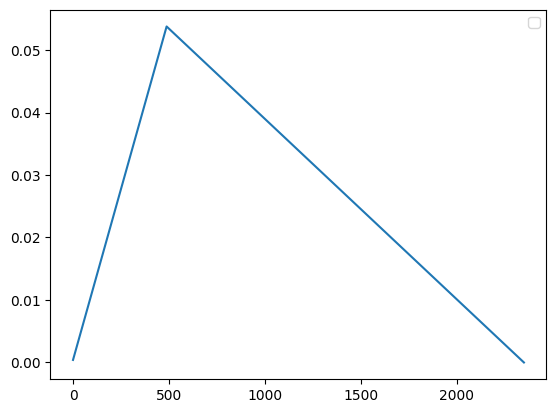

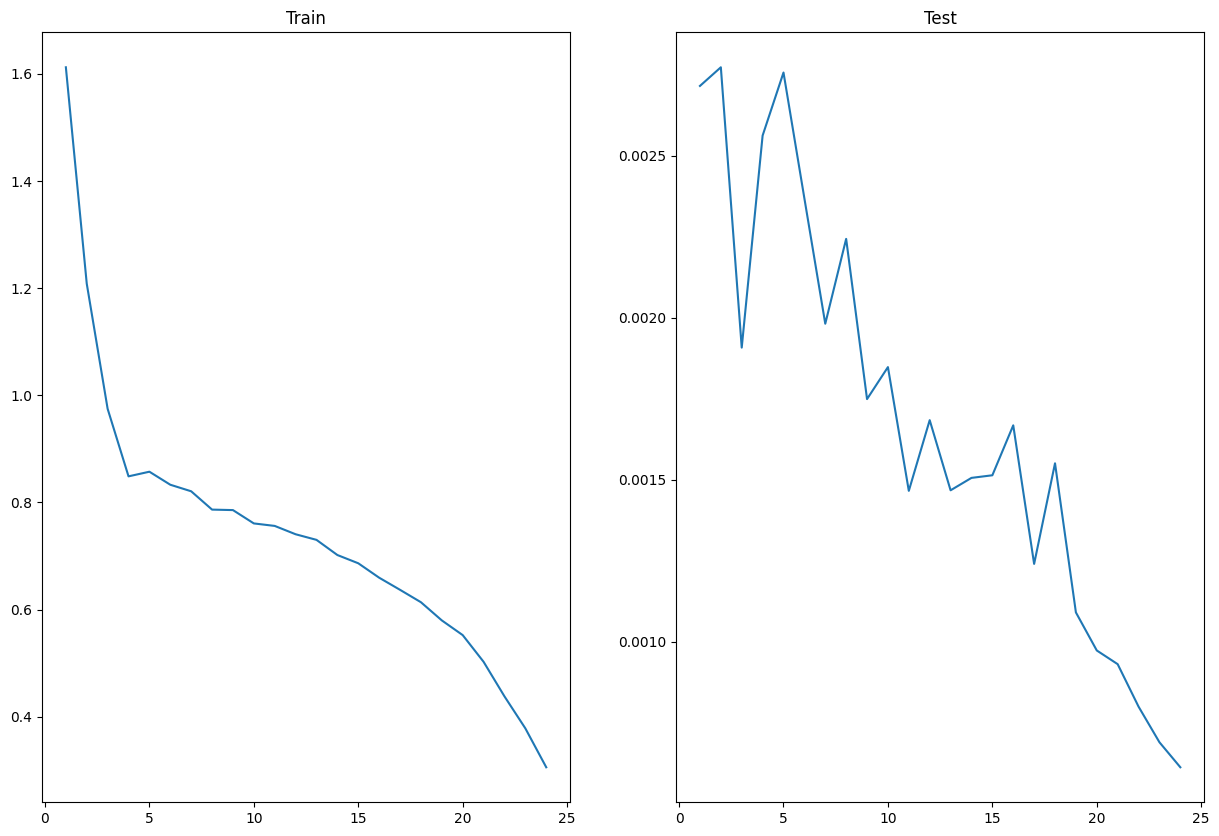

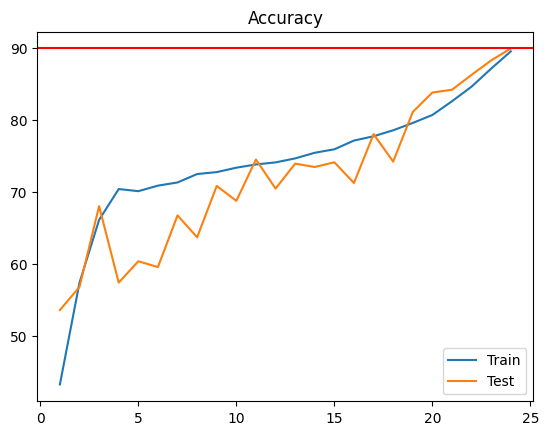

In [29]:
this_scheduler = OneCycleLR(
        optim_obj.optimizer,
        max_lr = max_lr,
        steps_per_epoch=len(optim_obj.train_loader),
        epochs = num_epochs,
        pct_start = 5./num_epochs,
        div_factor=200,
        three_phase=False,
        #final_div_factor=1000,
        anneal_strategy='linear',
        verbose=False
        )
plot_lr_values(this_scheduler, num_epochs, len(train_loader))
plot_losses(train_losses, test_losses)
plot_accuracy(train_acc, test_acc, target_test_acc=90.)


Print Training Log

In [30]:
print_train_log(train_acc, test_acc, train_losses, test_losses)

+-------+---------------------+-----------------------+----------------+--------------+
| Epoch |      Train loss     |        Val loss       | Train Accuracy | Val Accuracy |
+-------+---------------------+-----------------------+----------------+--------------+
|   1   |  1.6122256444424998 |  0.002715242600440979 |     43.198     |    53.55     |
|   2   |  1.2082595180492013 |  0.00277282212972641  |     57.36      |    56.77     |
|   3   |  0.974612656296516  | 0.0019076109290122986 |     66.094     |    68.01     |
|   4   |  0.8485822105894283 | 0.0025620359778404235 |     70.386     |    57.37     |
|   5   |  0.857240832581812  |  0.002756582176685333 |     70.09      |    60.34     |
|   6   |  0.8329375295006499 |  0.002368230175971985 |     70.858     |    59.53     |
|   7   |  0.8206970758584081 |  0.001981301772594452 |     71.302     |    66.72     |
|   8   |  0.7865010962194326 | 0.0022432290077209474 |     72.472     |    63.67     |
|   9   |  0.7855911285293345 | 